##  <div align="center">Итоговомый проект по курсу "Библиотеки Python для Data Science"</dev>

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from math import ceil
from pylab import rcParams
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score as r2
from inspect import getfullargspec

%matplotlib inline
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 8

pd.options.display.max_columns = 100

In [176]:
train_data = pd.read_csv('train.csv')

train_data.sample(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1645,11542,44,1.0,36.632064,21.867570,9.0,13,12.0,1974,0.036122,B,B,24,4378,0,1036.0,1,1,B,160587.240424
3550,668,3,1.0,33.253610,20.129591,7.0,13,12.0,1975,0.265089,B,B,37,5288,0,1937.0,3,2,B,220415.022641
1768,14582,13,1.0,39.048867,18.410816,10.0,10,14.0,2000,0.090799,B,B,74,19083,2,NaN,5,15,B,188965.103996
1660,8175,23,1.0,35.868665,NaN,0.0,5,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,92855.410323
7628,7837,42,1.0,38.785684,23.316841,7.0,10,17.0,2009,0.158249,B,B,21,5731,0,NaN,1,0,B,160877.002023
731,1634,23,1.0,34.002668,30.733024,0.0,2,2.0,2016,0.034656,B,B,0,168,0,NaN,0,0,B,74010.180152
8858,5274,21,3.0,84.565747,50.650809,8.0,5,12.0,1985,0.194489,B,B,47,8004,3,125.0,3,5,B,343760.813613
3484,13633,72,2.0,44.489616,23.253296,5.0,14,14.0,1978,0.210473,B,B,11,2398,2,1994.0,3,0,B,197781.397013
4282,13146,74,1.0,46.449711,NaN,0.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148
4971,8310,20,2.0,54.443402,33.129753,8.0,18,17.0,2000,0.019509,B,B,37,7687,11,176.0,5,5,B,341111.863221


### Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [177]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Exploratory data analysis

При изучении вещественных признаков необходимо ознакомиться с их основными статистиками используя функцию describe(). Исследуя ее показания можно понять где есть пропуски, с помощью count - если здесь не 10000, значит есть пропуски, по сравнению средней - mean с медианой - 50 персентилем можно судить о наличие выбросов при их существенных отличиях. Так же здесь стоит посмотреть на минимальные - максимальные значения, их сопоставления с другими статистиками даст представление о наличие некоректных значений в данных.

In [178]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Анализ количества уникальных значений признаков позволит разделить их на количественные и номинальные

In [179]:
# кол-во значений в признаках
# переведем признаки с небльшим кол-во значений в категориальные
pd.DataFrame({item:len(train_data[item].unique()) for item in train_data[train_data.columns.tolist()]}.items(), \
columns = ['Name', 'Count']).sort_values(by='Count')

,Name,Count
18,Shops_2,2
10,Ecology_2,2
11,Ecology_3,2
16,Helthcare_2,7
2,Rooms,9
17,Shops_1,16
14,Social_3,30
6,Floor,33
7,HouseFloor,44
12,Social_1,51


### Класс конвейера
Данный класс предназначен для интеграции операций трансформации данных,обучения модели на них и предсказания целевой перменной, а также визуализации данных. Инициализация объекта класса задает основные стат. параметры и загружает тренеровочный и тестовый набор данных, метод transform выполняет нормализацию и стандартизацию данных, методы fit и predict выполняют обучение модели и предсказание зависимой переменной на ней, методы plot, scatterplot, boxplot, corrplot отвечают за визуализацию данных в виде схем и графиков, вспомогательные методы _transform_cat_, _transform_num_ нормализуют номинальные и количественные признаки, а метод _resize_ рекурсивно понижает размерность данных, позволяя модели проводить более эффективное обучение.
Вспомогательные класс DataFrame расширяет стандартную функциональность Pandas вводя в стандартную реализацию количественные и категориальные признаки, класс Features обеспечивает создание дополнительных признаков, выполняя, в том числе, target кодирование на обучающем наборе и перенося его на тестовый.

In [192]:
class DataFrame(pd.DataFrame):
    """расширение DataFrame"""
    @property    
    def columns_num(self):
        """количественные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['uint8', 'int32', 'int64', 'float32', 'float64']).columns.tolist()
        
    @property    
    def column_cat(self):
        """номинативные признаки"""
        return self[self.columns.tolist()].select_dtypes(include=['object', 'category']).columns.tolist()                                  
        
    def columns_except(self, columns, excepts):
        return [item for item in columns if item not in excepts]                         
    
class DataPipeline:     
    def __init__(self, **kwargs):
        """Инициализация класса"""                 
        # уровень стат значимости
        self.alpha = 0.05
        # срнднйи уровень корреляции
        self.corr = 0.7
        # объясненная дисперсия компонента
        self.varatio = 0.8
        # пороговое значение в три сигмы
        self.threashold = 3    
        # пропорции деления набора
        self.test_size = 0.33
        
        # параметры класса
        for key, value in kwargs.items():
            setattr(self, key, value)    
            
        assert self.target is not None                  
        assert self.feature is not None                  
            
        # загрузка обучения    
        assert self.train_file is not None
        self.train_data = DataFrame(pd.read_csv(self.train_file))
        # загрузка теста
        assert self.test_file is not None                   
        self.test_data = DataFrame(pd.read_csv(self.test_file))                
    
    def sc_data(func):
        """Декоратор стандартизации"""
        def wrapper(self):         
            scaler = StandardScaler()                                                            
            # стандартизация обучения                    
            self.sc_train_data = func(self, self.train_data)
            # нормированная целевая переменная
            self.train_data[self.target] = self.sc_train_data[self.target]
            # исключение целевой переменной из количественных признаков            
            column = self.sc_train_data.columns_except(self.sc_train_data.columns_num, self.target)
            # стандартизация признаков                            
            self.sc_train_data = DataFrame(pd.concat([DataFrame(scaler.fit_transform(self.sc_train_data[column]), columns=column),\
                                                      self.sc_train_data[self.sc_train_data.column_cat]], axis=1))            
            print("train resize")
            # понижение размерности                   
            self.sc_train_data = DataFrame(self._resize_(self.sc_train_data))                        
                        
            # стандартизация теста            
            self.sc_test_data = func(self, self.test_data)                             
            # стандартизация признаков            
            self.sc_test_data = DataFrame(pd.concat([DataFrame(scaler.transform(self.sc_test_data[self.sc_test_data.columns_num]),\
                                                     columns=self.sc_test_data.columns_num), self.sc_test_data[self.sc_test_data.column_cat]], axis=1))                         
            print("test resize")         
            # понижение размерности            
            self.sc_test_data = DataFrame(self._resize_(self.sc_test_data))                        
                        
        return wrapper    
    
    @sc_data
    def transform(self, data):       
        """Трансформация данных"""       
        # удаляем id
        data.drop("Id", axis=1, inplace=True, errors="ignore")                                       
        # значений не много переводим в категориальный тип
        data.DistrictId = data.DistrictId.astype("category")                
        data.Social_3 = data.Social_3.astype("category")                    
        data.Helthcare_2  = data.Helthcare_2.astype("category")        
        
        # заменяем inf на nan тогда моедль сможет их предсказать
        data.replace([np.inf, -np.inf], np.nan, inplace = True)
        
        # добавление признаков
        data = self.feature.create(data, self.target)                      

        # обработка номинальных признаков
        for item in data.column_cat:        
            data = self._transform_cat_(data, item)            
        
        # обработка количественных признаков
        for item in data.columns_num:
            data = self._transform_num_(data, item)                                                         
        
        return data
            
    def _transform_cat_(self, data, column):
        """Трансформация номинальных признаков"""                
        # заменяем пропуски модой                                   
        data[column] = data[column].fillna(data[column].mode()[0])                    
        # кодируем признак
        data[column] = LabelEncoder().fit_transform(data[column])
        # возвращаем тип признака из числового после кодирования
        data[column] = data[column].astype("category")
        
        return data
        
    def _transform_num_(self, data, column):        
        """Трансформация количественных признаков"""        
        # пробуем предсказать пропуски                        
        cdata = DataFrame(data.copy()) 
        # запомнинание пропусков        
        cdata['isna'] = np.where(cdata[column].isna(), True, False)                                             
        # заполнение пропусков в копии, т.к моедель не работает с ними
        for item in cdata.column_cat:
            cdata[item] = cdata.fillna(cdata[item].mode())        
        for item in cdata.columns_num:
            cdata[item] = cdata.fillna(cdata[item].mean())                   
        # предсказание пропусков если можно сформировать обучающий и тестовый набор
        if True in cdata['isna'].values and False in cdata['isna'].values:
            # используем простую модель
            model = LinearRegression()
            # формируем тестовый и обучающий набор
            X_test = cdata[cdata['isna']==True][cdata.columns_except(cdata.columns, column)]
            X_train = cdata[cdata['isna']==False][cdata.columns_except(cdata.columns, column)]        
            y_train = cdata[cdata['isna']==False][column]                    
            # обучение модели
            model.fit(X_train, y_train)
            # выполняем предсказание пропущенного прзнака        
            data.loc[cdata['isna'], [column]] = model.predict(X_test)                                      
        
        # очень странно, если не трогать целевую переменную или выполнить её винсоризацию,
        # то результат обучения модели существенно лучше, хотя мат статистика по ней хуже чем после zscore?
        # bins по целевой переменной решает проблему статистики, но предсказание модели теперь имеют погрешность бина
        if column == self.target:            
            data[column] = data[column] // 10000 * 10000
        #    data[column] = winsorize(data[column], limits=[0.1, 0.1])                                                            
        
        # обработка выбрасов, вычисляем z-Score в цикле пока не подавим их все       
        while column != self.target:            
            z = np.abs(stats.zscore(data[column]))                                                     
            if not z[z > self.threashold].any():
                break            
            # среднее если данные имеют нормальное распределение, иначе медиана                                    
            if stats.shapiro(data[column].values.reshape(-1))[1] > self.alpha:                        
                data.loc[z > self.threashold, column] = data[column].mean()            
            else:            
                data.loc[z > self.threashold, column] = data[column].median()                                                          
        
        return data          
    
    def _resize_(self, data, level = 0):
        """понижение размерности"""           
        m_corr, level = data.corr(), level + 1        
        for item in m_corr.columns:            
            # поиск взаимокорреляции признаков по матрице
            column = list(m_corr[m_corr[item] > self.corr].index)
            # корреляция не с самим собой и не одни компоненты 
            if len(column) > 1 and not all('component' in item for item in column):
                dim_reducer = PCA(n_components=1, random_state=42)                
                components = dim_reducer.fit_transform(data[column])                            
                # уровень дисперсии достаточен для свертывания
                if dim_reducer.explained_variance_ratio_ >= self.varatio:
                    data = DataFrame(pd.concat([data.drop(column, axis=1),\
                                                pd.DataFrame(data = components, columns = [f'component_{level}'])], axis=1))                                                                                                
                    # результат свертки
                    print(f'{column} -> component_{level} var:{dim_reducer.explained_variance_ratio_}')
                    # рекурсивный поиск компонент
                    return self._resize_(data, level)               
        return data                
    
    def split(self, X, y):
        """Разделение набора"""             
        return train_test_split(X, y, test_size=self.test_size, random_state=42)
    
    def search_param(self, data):
        """Поиск гиперпараметров"""        
        params = {
            'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson', 'gini', 'entropy'],
            'n_estimators': [item for item in range(10, 100, 10)],            
            'max_depth': [item for item in range(1, 10, 2)],
            'max_features': [item for item in range(1, 10, 2)],
            'min_samples_leaf': [item for item in range(1, 10, 2)],
        }

        clf = GridSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_grid=params,            
            scoring='r2',
            n_jobs=-1,
            cv=5
        )              
        # формируем X и y из обучающего набора
        X_train, X_valid, y_train, y_valid = self.split(self.sc_train_data, self.train_data[self.target])
        # искать праметры лучше на всеъ данных
        clf.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))
        
        return clf.best_params_
    
    def fit(self, model, data):
        """Обучение модели"""                     
        # разделение набора на обучающий и проверочный
        X_train, X_valid, y_train, y_valid = self.split(data[data.columns_except(data.columns, self.target)], data[self.target])
        
        model.fit(X_train, y_train)                
        
        return model
        
    def predict(self, model, data):
        """Предсказание зависимой переменной"""        
        return model.predict(data)    
    
    def importances(self, model, data):
        """оценка признаков модели"""                                
        return pd.DataFrame(zip(data.columns_except(data.columns, self.target), model.feature_importances_),\
                            columns = ['name', 'value']).sort_values(by = 'value', ascending = False)                          
    
    def scatterplot(self, model, data):
        """график scatterplot качесива модели"""    
        X_train, X_valid, y_train, y_valid = self.split(data[data.columns_except(data.columns, self.target)], data[self.target])

        y_pred = self.predict(model, X_train)

        plt.subplot(121)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')        
        plt.title(f"train R2:{round(r2(y_train, y_pred), 3)}")
        sns.scatterplot(x = y_train, y = y_pred)
        
        y_pred = self.predict(model, X_valid)        

        plt.subplot(122)
        plt.xlabel('Predicted values')
        plt.ylabel('True values')                
        plt.title(f"valid R2:{round(r2(y_valid, y_pred), 3)}")
        sns.scatterplot(x = y_valid, y = y_pred)

        plt.show()                  
        
    def plot(self, data):      
        """график plot"""            
        data[[item for item in data.columns_num if item != self.target]].hist(figsize=(16,16), bins=20, grid=False);
        
        plt.figure(figsize = (16, 8))
        sns.distplot(data[self.target], bins=50)  
        
        target_mean = round(data[self.target].mean(), 2)
        target_median = data[self.target].median()
        target_mode = data[self.target].mode()[0]        

        y = np.linspace(0, 0.000005, 10)
        plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
        plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
        plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

        plt.title(f'Distribution of {self.target}')
        plt.legend()            
        plt.show()        

    def boxplot(self, data):
        """график box-plot"""                           
        data.boxplot(column = [item for item in data.columns_num], grid = False, rot = 45)
        
    def corrplot(self, data):
        """график корреляции"""              
        plt.title('Корреляционная матрица')
        sns.heatmap(data.corr(), annot = True)
        plt.show()  
        
class Features:
    """Генератор признаков"""    
    def create(self, data, target):
        # кол-во комант по этажности в районах            
        data = data.merge(data.groupby(['DistrictId', 'HouseFloor'], as_index=True).agg({'Rooms':'sum'}).\
                          rename(columns={'Rooms':'RoomsByDistrict'}), on=['DistrictId', 'HouseFloor'], how='left')                
        
        # экология в районах
        data = data.merge(data.groupby(['DistrictId', 'Ecology_2'], as_index=True).agg({'Ecology_1':'sum'}).\
                          rename(columns={'Ecology_1':'EcologyByDistrict'}), on=['DistrictId', 'Ecology_2'], how='left')                        
        
        # кол-во магазинов различного типа в районах
        data = data.merge(data.groupby(['DistrictId', 'Shops_2'], as_index=True).agg({'Shops_1':'sum'}).\
                          rename(columns={'Shops_1':'ShopsByDistrict'}), on=['DistrictId', 'Shops_2'], how='left')                                
        
        # размер района
        data = data.merge(data['DistrictId'].value_counts().reset_index().\
                          rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'}), on=['DistrictId'], how='left')
                
        data['DistrictSize'] = np.where(data['DistrictSize'] > 100, True, False)                             
        
        # Категории домов по году строительства
        data['HouseYearCat'] = pd.cut(data['HouseYear'], bins=[data['HouseYear'].min() - 1,\
                                                               1941, 1945, 1980, 2000, 2010,\
                                                               data['HouseYear'].max() + 1], labels=False).astype("category")        
        
        data = data.merge(data.groupby(['DistrictId'], as_index=False).agg({'HouseYearCat':'count'}).\
                          rename(columns={'HouseYearCat':'HouseCountByDistrict'}), on=['DistrictId'], how='left')                     
                
        # высота района
        data = data.merge(data.groupby(['DistrictId'], as_index=False).agg({'HouseFloor':'sum'}).\
                          rename(columns={'HouseFloor':'HeightByDistrict'}), on=['DistrictId'], how='left')             
        
        # Средняя площадь комнаты по районам
        data = data.merge(data.groupby(['DistrictId'], as_index=True).agg({'Square':'sum', 'Rooms':'sum'}).\
                          rename(columns={'Square':'SumSquareByDistrict', 'Rooms':'SumRoomsByDistrict'}),\
                          on=['DistrictId'], how='left')                
        
        data["RoomsSquareByDistrict"] = data["SumSquareByDistrict"] / data["SumRoomsByDistrict"]        
        data.drop(["SumSquareByDistrict", "SumRoomsByDistrict"], axis=1, inplace=True)  
        
        # Мед обслуживание по районам
        data = data.merge(data.groupby(['DistrictId', 'Social_3'], as_index=True).agg({'Social_1':'sum', 'Social_2':'sum'}).\
                          rename(columns={'Social_1':'SumSocial_1', 'Social_2':'SumSocial_2'}),\
                          on=['DistrictId', 'Social_3'], how='left')                
        
        data["SocialByDistrict"] = data["SumSocial_2"] / data["SumSocial_1"]        
        data.drop(["SumSocial_1", "SumSocial_2"], axis=1, inplace=True)                   
        
        # dummies кодирование для признаков с двумя значениями
        columns = ['DistrictSize', 'Ecology_2', 'Ecology_3', 'Shops_2']
        data = pd.get_dummies(data, columns=columns)
        
        for item in data.columns:
            if any(column for column in columns if column in item):
                data[item] = data[item].astype("category")                        
                
        # target кодирование
        if target in data.columns:            
            # средняя цена за квадратный метр по району
            self.SquareAvgPriceByDistrict = data.groupby(['DistrictId', 'HouseFloor'], as_index=True).\
            agg({'Square':'sum', 'Price':'sum'}).rename(columns={'Square':'SumSquareByDistrict', 'Price':'SumPriceByDistrict'})            
            self.SquareAvgPriceByDistrict['SquareAvgPriceByDistrict'] = self.SquareAvgPriceByDistrict['SumPriceByDistrict'] \
                                                                      / self.SquareAvgPriceByDistrict['SumSquareByDistrict']            
            self.SquareAvgPriceByDistrict.drop(["SumSquareByDistrict", "SumPriceByDistrict"], axis=1, inplace=True)                   
            # стоимость домов по году строительства на районе
            self.HouseYearPriceByDistrict = data.groupby(['DistrictId', 'HouseYear'], as_index=True).\
            agg({'Price':'median'}).rename(columns={'Price':'YearPriceByDistrict'})            
            # стоимость комнат по районам
            self.HouseRoomsPriceByDistrict = data.groupby(['DistrictId', 'Rooms'], as_index=True).\
            agg({'Price':'median'}).rename(columns={'Price':'RoomsPriceByDistrict'})         

        # добавляем расчитанные на train данные в набор        
        data = data.merge(self.SquareAvgPriceByDistrict, on=['DistrictId', 'HouseFloor'], how='left')                                        
        data = data.merge(self.HouseYearPriceByDistrict, on=['DistrictId', 'HouseYear'], how='left')
        data = data.merge(self.HouseRoomsPriceByDistrict, on=['DistrictId', 'Rooms'], how='left')        
        
        return DataFrame(data)    

In [181]:
# создамие конвейера
pipeline = DataPipeline(feature=Features(), train_file="train.csv", test_file="test.csv", target='Price')

Визулизация признаков и целевой переменной.

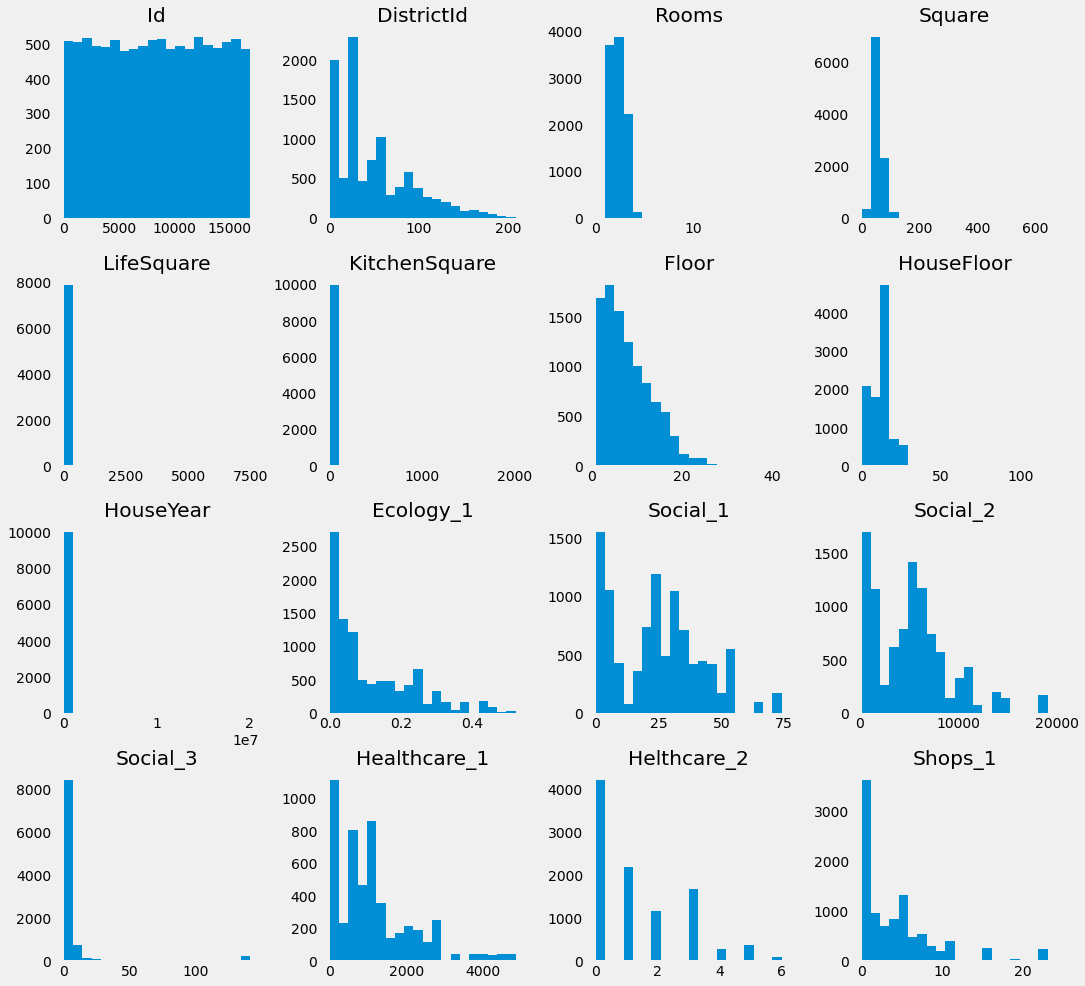

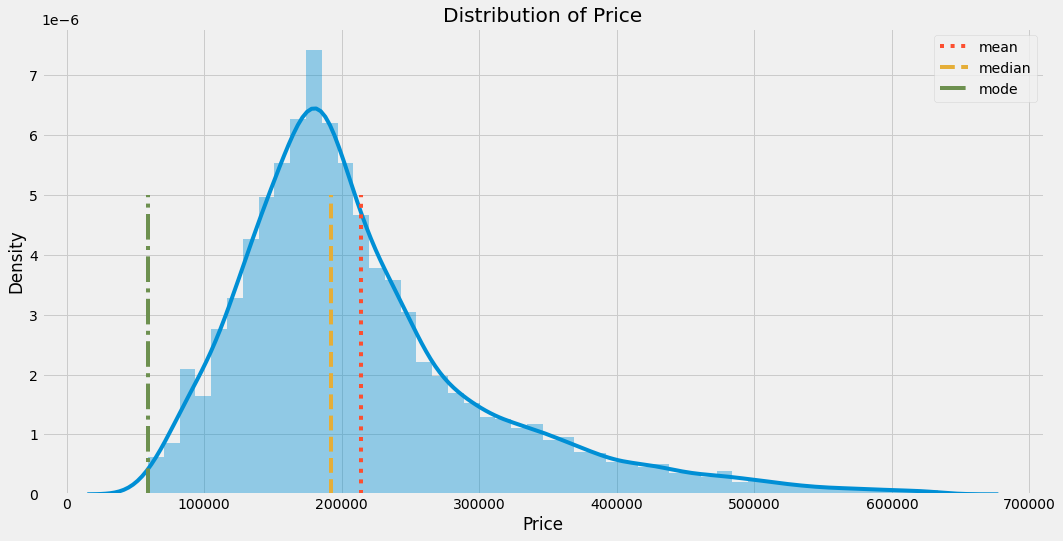

In [182]:
pipeline.plot(pipeline.train_data)

Целевая переменная вещественная, для ее предсказания используем регрессию, перед этим нормализуем и стандартизируем данные, попутно пытаемся понизить их размерность.

In [183]:
# подготовка признаков
pipeline.transform()
# масштабированный и нормализованный набор
df = DataFrame(pd.concat([pipeline.sc_train_data, pipeline.train_data[pipeline.target]], axis=1))

train resize
['Rooms', 'Square'] -> component_1 var:[0.88669833]
['Social_1', 'Social_2'] -> component_2 var:[0.94198465]
['HouseCountByDistrict', 'HeightByDistrict'] -> component_3 var:[0.98596368]
test resize
['Rooms', 'Square'] -> component_1 var:[0.88488028]
['Social_1', 'Social_2'] -> component_2 var:[0.94139093]
['HouseCountByDistrict', 'HeightByDistrict'] -> component_3 var:[0.98718295]


In [184]:
df.sample(5)

,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Healthcare_1,Shops_1,RoomsByDistrict,EcologyByDistrict,ShopsByDistrict,RoomsSquareByDistrict,SocialByDistrict,SquareAvgPriceByDistrict,YearPriceByDistrict,RoomsPriceByDistrict,DistrictId,Social_3,Helthcare_2,HouseYearCat,DistrictSize_False,DistrictSize_True,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,component_1,component_2,component_3,Price
7744,-0.150730,-1.219789,-0.879308,1.005140,-0.440038,-1.009302,1.953828,-0.111514,-0.741376,-0.854982,-0.159935,1.513896,1.621556,-2.748844,-0.491958,-0.392094,30,29,3,2,0,1,0,1,0,1,0,1,0.367305,0.147570,-0.012890,130000.0
1715,0.937368,0.096170,0.345241,-0.545763,-0.770504,0.511387,-0.615001,-1.084587,1.196805,-0.310956,-0.452018,-1.015021,1.344757,0.194056,0.129670,1.731305,41,3,1,2,1,0,0,1,0,1,0,1,1.336356,1.438545,-0.823299,240000.0
3276,-0.805717,0.622554,-0.675216,0.694960,0.606439,-0.403768,-0.696794,2.483346,2.101289,1.385663,2.499372,0.062457,0.830690,-0.184712,0.107142,-1.096006,9,4,1,3,0,1,0,1,0,1,0,1,-1.498697,2.842176,0.179801,170000.0
3707,0.265967,1.412129,1.365698,0.694960,1.102138,-1.009981,-0.643117,1.510273,1.498300,-0.843637,0.437814,-0.235263,-1.098068,0.592685,-0.098722,0.902273,128,0,2,4,1,0,0,1,0,1,0,1,0.576332,0.031461,-0.903143,340000.0
1631,-0.629626,0.622554,0.957515,0.229689,0.275972,0.365331,-0.681458,-1.084587,-0.741376,-0.573477,-1.219583,1.053807,1.190862,0.359853,-0.024103,-0.545003,15,0,1,3,1,0,0,1,0,1,0,1,-1.439407,-0.025235,-1.067839,190000.0


Визуализация признаков и целевой переменной после нормализации и стандортизации.

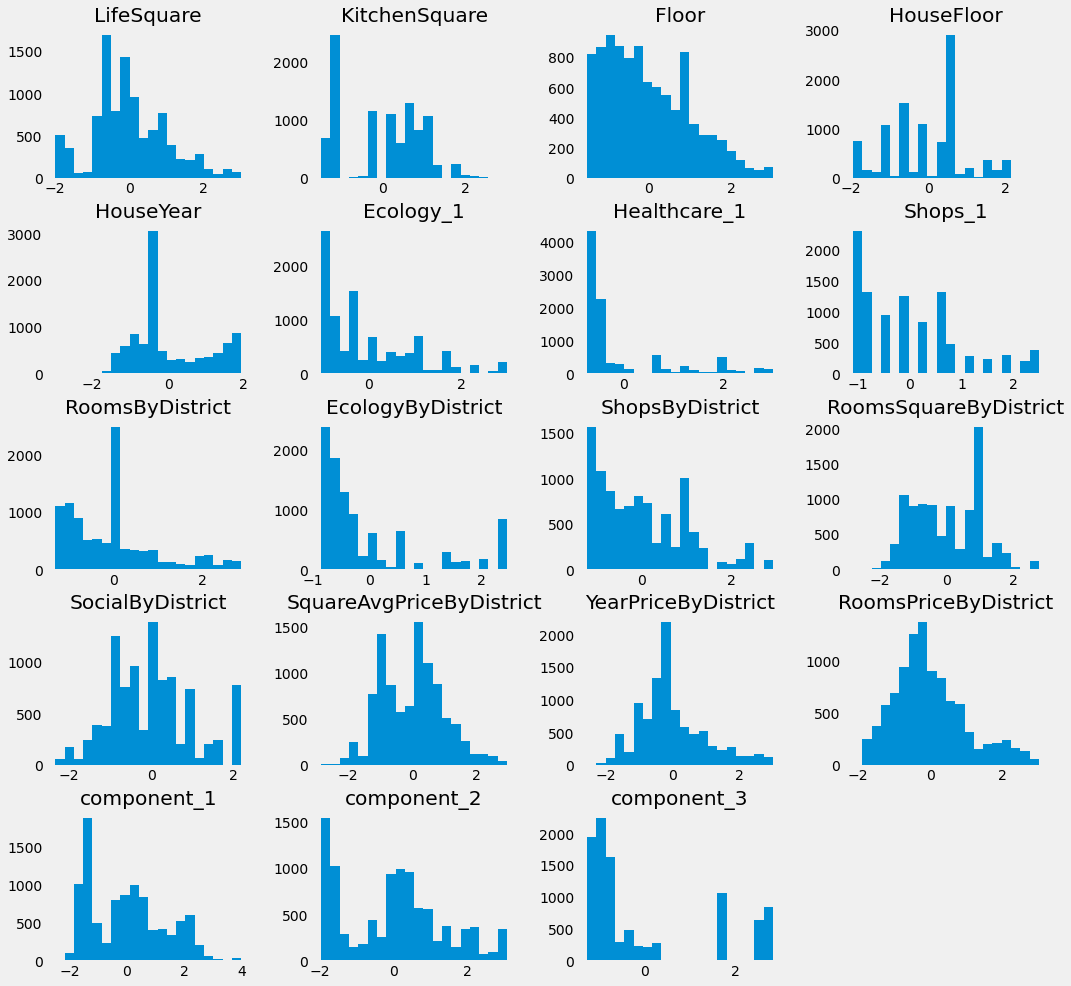

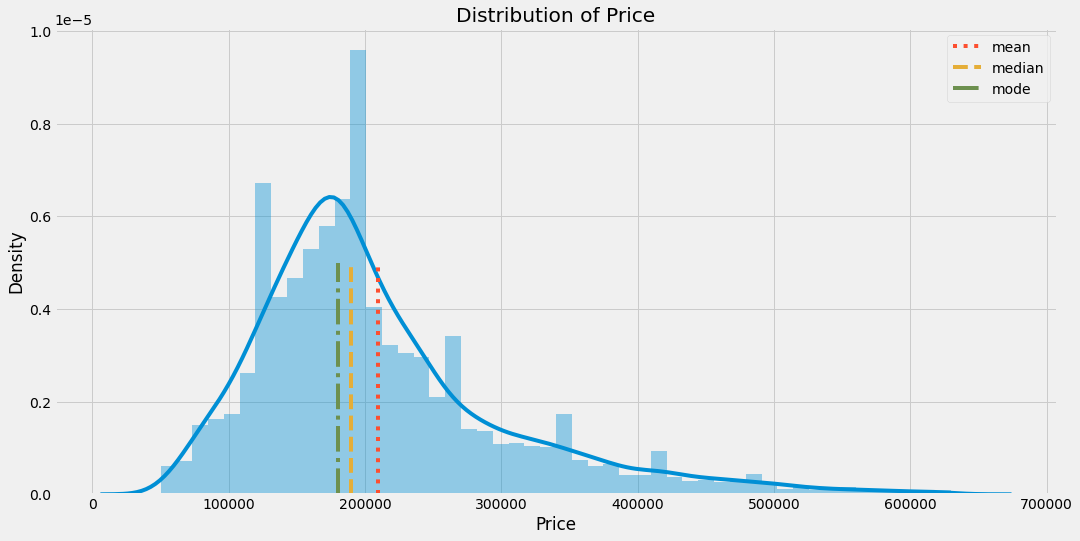

In [185]:
# распределение количественных признаков в исходных данных 
# целевой переменной и ее статистические данные
pipeline.plot(df)

После обработки количественные признаки приняли соразмерный формат выбросы в них подавлены.

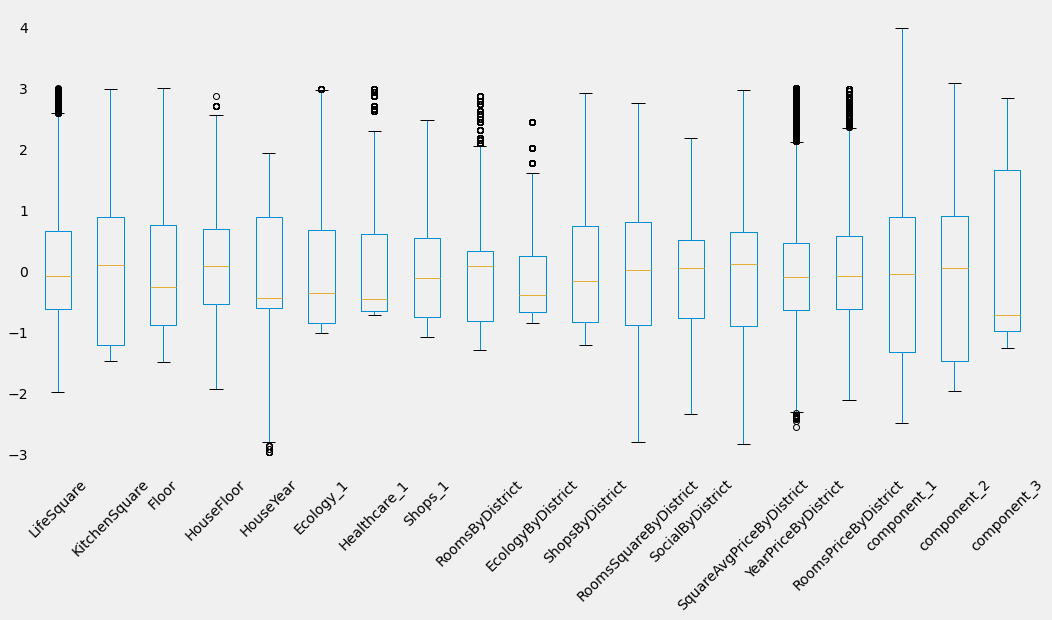

In [186]:
# визуализация выбросов после обработки признаков
pipeline.boxplot(pipeline.sc_train_data)

Корреляционная матрица позволит убедиться в устранении взаимокрреляции признаков, уровень которой устанволен при инициализации объекта класса в свойстве corr.

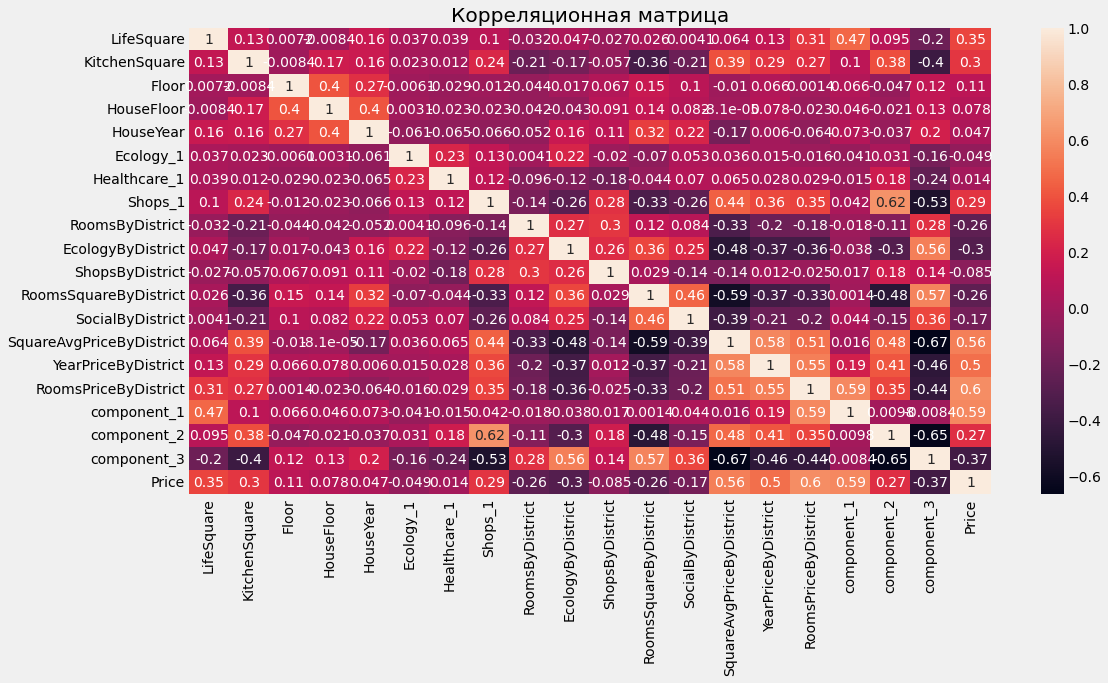

In [187]:
# корреляция признаков с целевой переменной их сильные взаимокорреляции устранены PCA
pipeline.corrplot(df)

Выполнение обучения модели и предсказание целевой переменной. Оценка качества обучения демонстрирует не плохие результаты, но как видно из анализа признаков модели, они были достигнуты благодоря target кодированию, что не позволяет говорить об устойчивости модели при предсказании на случайной выборке данных.

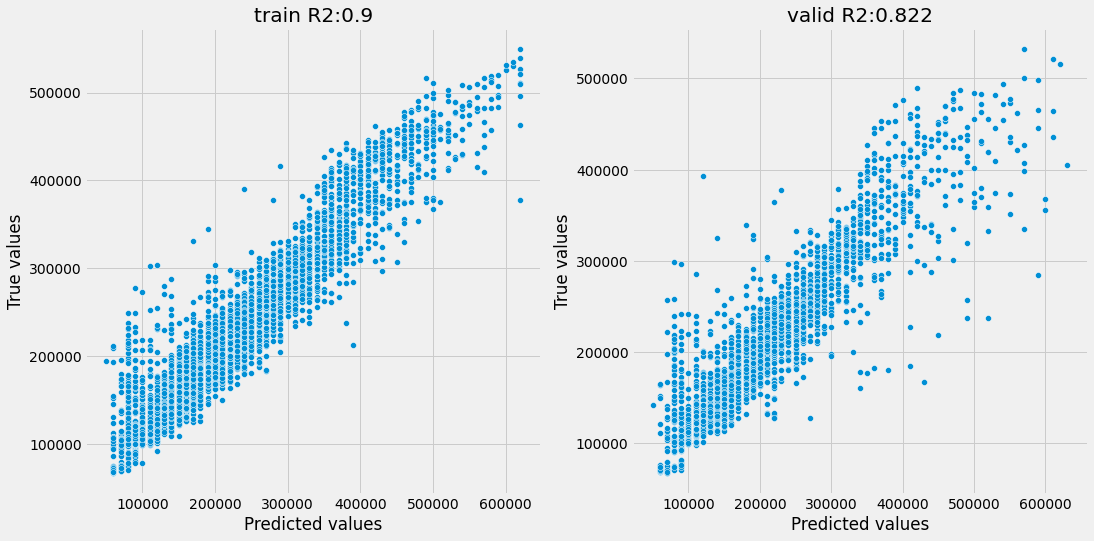

Wall time: 3.39 s


,name,value
14,YearPriceByDistrict,0.222744
15,RoomsPriceByDistrict,0.208760
28,component_1,0.184903
13,SquareAvgPriceByDistrict,0.120128
0,LifeSquare,0.073099
30,component_3,0.034687
29,component_2,0.022496
8,RoomsByDistrict,0.016991
1,KitchenSquare,0.015656
4,HouseYear,0.010767


In [188]:
%%time
# определение оптимальных гипрепараметров модели
#params = pipeline.search_param(pipeline.train_data)

#print(params)

params = {'criterion': 'friedman_mse', 'max_depth': 9, 'max_features': 9, 'n_estimators': 90, 'random_state': 42}
# обучение модели
model = pipeline.fit(RandomForestRegressor(**params), df)
# оценка результата обучения
pipeline.scatterplot(model, df)
# влияние признаков на процесс обучения
pipeline.importances(model, df)

Предсказание цены квартиры на тестовом наборе

In [189]:
# предсказание целевой переменой в test
pd.concat([pipeline.test_data, pd.DataFrame(data = pipeline.predict(model, pipeline.sc_test_data),\
                                            columns = [pipeline.target])], axis=1)   

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,208530.845687
1,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,232473.355845
2,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,156448.612993
3,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,299506.056947
4,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,124537.204085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B,244117.454106
4996,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B,137101.692748
4997,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B,298158.729120
4998,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,179258.420078
